<a href="https://colab.research.google.com/github/blackgreenc/Paper/blob/main/Tacotron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><strong>Tacotron논문</strong></h1>
<h2 style="color:red">이 논문의 큰 특징</h2>
<br>
<h3>
1, Attention기반 Seq-toSeq TTS 모델 구조를 제시함
<br>
2, <문장, 음성>쌍으로 이루어진 데이터만으로 <u>별도의 작업없이</u> 학습이 가능한 End-to-End 모델이다.
<br>
3, 음성합성 품질이 뛰어나다.
</h3>



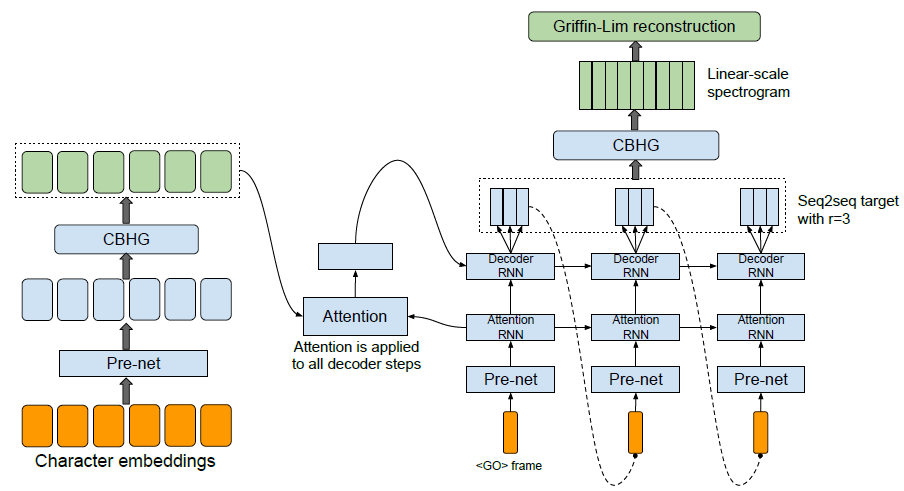

<h3>모델은 크게 문장을 input으로 받아 정보를 추출하는 Encoder,  Encoder로부터 추출된 정보를 이용하여 멜 스펙토그램을 생성하는 Decoder, Encoder의 정보를 Decoder에 mapping해주는 Attention, 마지막으로 Decoder에서 생성된 델 스펙토그램을 이용하여 Linear스펙토그램을 생성하는 후처리부분으로 나뉠 수 있다. 그리고 추가적으로 모델로부터 나온 최종 결과물인 Linear스펙토그램을 오디오로 바꿔주는 Grifin-Lim알고리즘이 있다. Encoder와 Decoder 안에는 공통적으로 반복되는 CBHG공통 모듈이 존재한다.</h3>

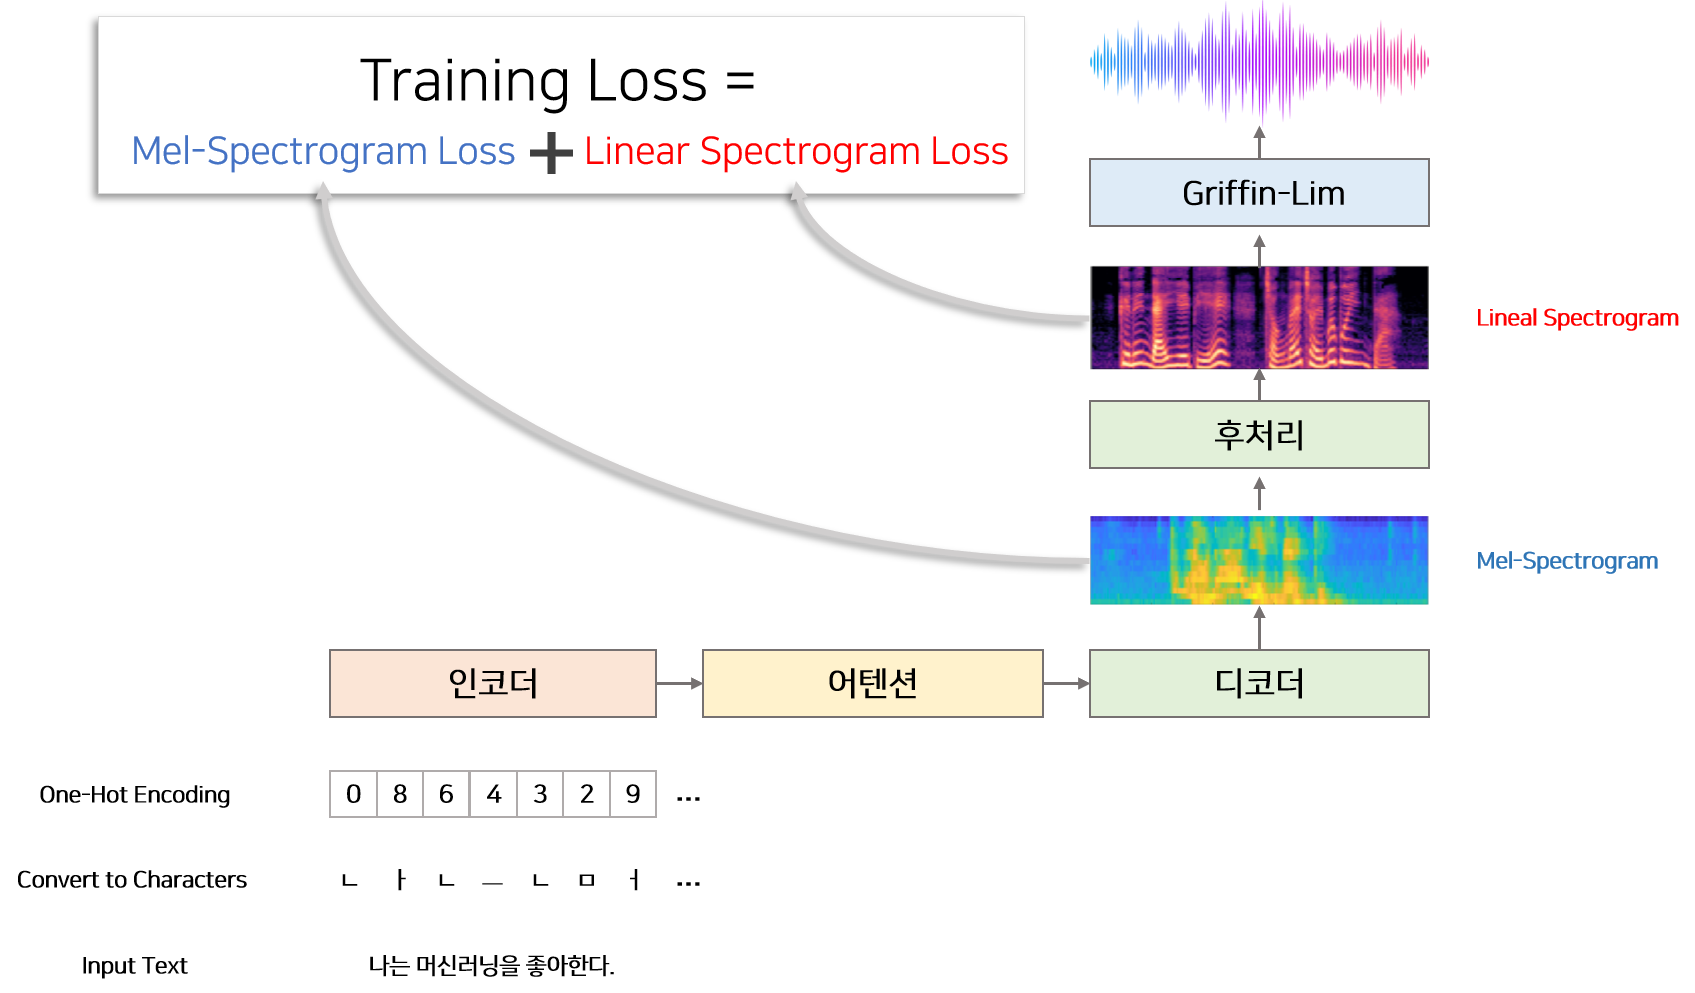

<h3>모델의 Training 및 Inference단계에서 input은 character단위의 One-hot vector이다. 따라서 영어 문장을 모델에 넣기 위해서는 문장을 character단위로 나누고 One-hot Encoding하는 작업이 필요합니다. 예를들어 'I love you'문장은 각각 한개의 character 'i', '', 'l', 'o', 'v', 'e', 'y', 'o', 'u'로 나누고 One-hot Encoding을 통해 각 character에 맞는 숫자열[8, 6, 13, ...., 2]로 변형한 뒤 모델의 input으로 사용한다. 한글의 경우 문장을 초성, 중성, 종성, 그리고 문장 부호로 나누어 총 80개의 character로 문자를 나누고 난 뒤 One-hot Encoding을 통해 숫자열로 변형한다.</h3>

<h4><i>한글의 경우 초성과 종성의 자음은 각각 다른 Character로 Embading하여 처리한다. 예를 들어 나는 ==>[ㄴ,ㅏ, ㄴ, ㅡ, ㄴ] -> [2, 4, 2, 5, 8]으로 표현된 것처럼 'ㄴ'은 초성, 종성에 따라 다르게 Embading된다.</i></h4>

모델의 Inference단계에서 Output은 Linear 스펙트로그램입니다. 모델을 학습할 때에는 후처리 부분에서의 Output인 Linear스펙토그램 뿐만 아니라 Decoder부분에서의 Output인 멜 스펙토그램을 함께 사용합니다.